<a href="https://colab.research.google.com/github/JowenPang/Embark-P4-T1/blob/main/VehicleModelDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [122]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
import seaborn as sns


In [123]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [124]:
import pathlib

In [175]:
train_path = pathlib.Path('/content/drive/MyDrive/P4 - Team 1/Train')
test_path = pathlib.Path('/content/drive/MyDrive/P4 - Team 1/Test')

In [176]:
train_path

PosixPath('/content/drive/MyDrive/P4 - Team 1/Train')

**labelling the data**

In [177]:
model_images_dict = {
    'audi_ev':  list(train_path.glob('audi etron sportback/*')),
    'audi_nev':  list(train_path.glob('Audi A5 Coupe 2012/*')),
    'bmw_ev':  list(train_path.glob('bmw i4/*')),
    'bmw_nev':  list(train_path.glob('BMW X6 SUV 2012/*')),
}

In [178]:
model_labels_dict = {
    'audi_ev': 0,
    'audi_nev': 1,
    'bmw_ev': 2,
    'bmw_nev' : 3
}

In [179]:
model_images_dict['audi_ev'][:5]

[PosixPath('/content/drive/MyDrive/P4 - Team 1/Train/audi etron sportback/1.jpg'),
 PosixPath('/content/drive/MyDrive/P4 - Team 1/Train/audi etron sportback/3.jfif'),
 PosixPath('/content/drive/MyDrive/P4 - Team 1/Train/audi etron sportback/4.jfif'),
 PosixPath('/content/drive/MyDrive/P4 - Team 1/Train/audi etron sportback/5.jfif'),
 PosixPath('/content/drive/MyDrive/P4 - Team 1/Train/audi etron sportback/7.jfif')]

In [180]:
car_img = cv2.imread(str(model_images_dict['audi_ev'][2]))
car_img.shape

(168, 300, 3)

**processing image**

In [181]:
model_image, model_label = [], []

for model_name, images in model_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224))
        model_image.append(resized_img)
        model_label.append(model_labels_dict[model_name])

In [182]:
model_image = np.array(model_image)
model_label = np.array(model_label)

In [183]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(model_image,model_label , random_state=0)

In [184]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [185]:
model_image[6].shape

(224, 224, 3)

In [186]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [187]:
pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [192]:
num_of_cars_models = 4

In [193]:
model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_cars_models)
])

In [194]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_4 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_4 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 2,263,108
Trainable params: 5,124
Non-trainable params: 2,257,984
_________________________________________________________________


In [195]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [196]:
model.fit(X_train_scaled, y_train, epochs=7)

Epoch 1/7
4/4 [==============================] - 7s 668ms/step - loss: 1.5082 - acc: 0.2358
Epoch 2/7
4/4 [==============================] - 3s 640ms/step - loss: 1.2061 - acc: 0.4245
Epoch 3/7
4/4 [==============================] - 3s 641ms/step - loss: 0.9778 - acc: 0.7075
Epoch 4/7
4/4 [==============================] - 3s 646ms/step - loss: 0.8258 - acc: 0.7925
Epoch 5/7
4/4 [==============================] - 3s 652ms/step - loss: 0.6899 - acc: 0.8774
Epoch 6/7
4/4 [==============================] - 3s 635ms/step - loss: 0.5985 - acc: 0.8962
Epoch 7/7
4/4 [==============================] - 3s 629ms/step - loss: 0.5153 - acc: 0.9151


In [197]:
model.evaluate(X_test_scaled,y_test)

2/2 [==============================] - 1s 113ms/step - loss: 0.8290 - acc: 0.6667


[0.8289647698402405, 0.6666666865348816]

**predict image**

In [213]:
predict_img = '/content/drive/MyDrive/P4 - Team 1/bmw_ev.jfif'

In [214]:
image = cv2.imread(str(predict_img))
image.shape

(164, 308, 3)

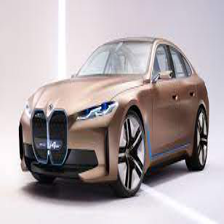

In [215]:
Image.open(predict_img).resize((224,224))

In [216]:

image = cv2.resize(image,(224,224))
image = np.array(image)
image = np.expand_dims(image, axis=0)
image = image/255.0


In [217]:
y_prob = model.predict(image)
y_prob

array([[-1.518282 , -0.7998482,  1.6329339, -2.3489318]], dtype=float32)

**0 - Audi A5 Coupe 2012 (non-EV)**


**1 - Audi Etron Sportback (EV)**

In [218]:
y_classes = np.argmax(y_prob)
y_classes

2